In [1]:
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#for live plotting
from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline

%run 2d_lipm_env.ipynb #imports LIPM Env

In [2]:
class Buffer:
    def __init__(self, buffer_size):
        
        self.buffer_size = buffer_size
        self.buffer = np.zeros((1, 5 + 2 + 1 + 5)) ## should be made variables
        
    def size(self):
        
        return len(self.buffer)
    
    def store(self, state, action, reward, next_state, done):
        ## stores new data in the buffer
        new_data = 9999*np.ones((1, 5 + 2 + 1 + 5))
        new_data[0, 0:5] = state
        new_data[0, 5:8] = [action[0], action[1], reward]
        if not done:
            new_data[0, 8:] = next_state 
        else:
            new_data[0, 8:] = [np.nan, np.nan, np.nan, np.nan, np.nan]
        self.buffer = np.concatenate((self.buffer, np.around(new_data, 2)), axis = 0)
        
        #removes the first element if it is zero.
        if np.all(self.buffer[0] == 0):
            self.buffer = self.buffer[1:]
            
        # removes first element if the desired buffer size is obtained
        elif self.size() > self.buffer_size:
            self.buffer = self.buffer[1:]
            
    def sample(self, batch_size):
        # returns a random mini batch of desired batch size
        return np.asarray(random.sample(list(self.buffer), batch_size))

In [3]:
class NN(nn.Module):
    def __init__(self, inp_size, out_size):
        
        super(NN, self).__init__()
        self.l1 = nn.Linear(inp_size, 2048)
        self.l2 = nn.Linear(2048, 2048)
        self.l3 = nn.Linear(2048, 1024)
        self.l4 = nn.Linear(1024, out_size)
    
    def forward(self, x):
        
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = self.l4(x)
        return x

In [5]:
class TwoDQStepper:
    def __init__(self, no_actions = [9, 7], lr = 1e-4, gamma = 0.9, use_tarnet = False, trained_model = None):
        '''
        This is a 2d dq stepper.
        State = [x-ux, y - uy, xd, yd, n, action_x, action_y]
        '''
        self.device = torch.device("cpu")
        self.dq_stepper = NN(7, 1).to(self.device) #state+ action -> q_value
        if trained_model:
            self.dq_stepper.load_state_dict(torch.load(trained_model))
            self.dq_stepper.eval()
        self.optimizer = torch.optim.SGD(self.dq_stepper.parameters(), lr)
        self.use_tarnet = use_tarnet
        if self.use_tarnet:
            self.dq_tar_stepper = NN(7, 1).to(self.device)
            self.dq_tar_stepper.load_state_dict(self.dq_stepper.state_dict())
            self.dq_tar_stepper.eval()
        self.gamma = gamma #discount factor
        assert len(no_actions) == 2
        self.no_actions = no_actions
        
        # This is the template of x_in that goes into the dq stepper
        self.x_in = np.zeros((self.no_actions[0]*self.no_actions[1], 7))
        self.x_in[:,5] = np.tile(np.arange(self.no_actions[0]), self.no_actions[1])
        self.x_in[:,6] = np.repeat(np.arange(self.no_actions[1]), self.no_actions[0])
                  
    def predict_action_value(self, x):
        # this function predicts the q_value for different actions and returns action and min q value
        self.x_in[:,[0, 1, 2, 3, 4]] = x
        torch_x_in = torch.FloatTensor(self.x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_stepper(torch_x_in).detach().numpy()
            action = np.argmin(q_values)
            action_x = int(action%self.no_actions[0])
            action_y = int(action//self.no_actions[0])
        return [action_x, action_y], q_values[action]
    
    def tar_predict_action_value(self, x):
        # this function uses tar net to predict 
        # the q_value for different actions and returns action and min q value
        self.x_in[:,[0, 1, 2, 3, 4]] = x
        torch_x_in = torch.FloatTensor(self.x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_tar_stepper(torch_x_in).detach().numpy()
            action = np.argmin(q_values)
            action_x = int(action%self.no_actions[0])
            action_y = int(action//self.no_actions[0])
        return [action_x, action_y], q_values[action]
    
    def predict_eps_greedy(self, x, eps = 0.1):
        # This function returns prediction based on epsillon greedy algorithm
        if np.random.random() > eps:
            return self.predict_action_value(x)[0]
        else:
            action_x = np.random.randint(self.no_actions[0])
            action_y = np.random.randint(self.no_actions[1])
            return [action_x, action_y]
        
    def optimize(self, mini_batch, tau = 0.001):
        # This function performs one step of back propogation for the given mini_batch data
        x_in = torch.FloatTensor(mini_batch[:,0:7].copy(), device = self.device)
        y_train = torch.FloatTensor(mini_batch[:,7].copy(), device = self.device)
        for i in range(len(mini_batch)):
            if not np.isnan(mini_batch[i,8:]).all():
                if not self.use_tarnet:
                    y_train[i] += self.gamma * self.predict_action_value(mini_batch[i,8:])[1]
                else:
                    y_train[i] += self.gamma * self.tar_predict_action_value(mini_batch[i,8:])[1]

        y_train = y_train.unsqueeze(1).detach() #ensures that gradients are not computed on this
        x_train = self.dq_stepper(x_in)

        loss = F.mse_loss(x_train, y_train)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        if self.use_tarnet:
            for tar_param, param in zip(self.dq_tar_stepper.parameters(), self.dq_stepper.parameters()):
                tar_param.data.copy_(tar_param.data * (1.0 - tau) + param.data * tau)
                
        return loss
    
    def live_plot(self, history, figsize=(7,5), title='history'):
        clear_output(wait=True)
        plt.figure(figsize=figsize)
        for label,data in history.items():
            plt.plot(data, label=label)
        plt.title(title)
        plt.grid(True)
        plt.xlabel('episode')
        plt.ylim(0, 200)
        plt.legend(loc='top right') # the plot evolves to the right
        plt.show();
        
    def predict_q(self, x):
        #for debugging
        # this function predicts the q_value for different actions and returns action and min q value
        self.x_in[:,[0, 1, 2, 3, 4]] = x
        torch_x_in = torch.FloatTensor(self.x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_stepper(torch_x_in).detach().numpy()
        return q_values

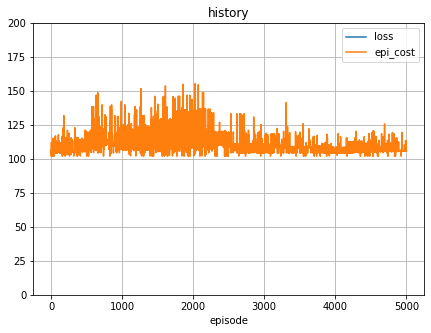

In [6]:
e = 1
no_epi = 5000
no_steps = 10 ## number of steps simulated per episode (pendulum steps)
step_time = 0.1 ## time after which step is taken
env = TwoDLipmEnv(0.2, 0.16, 0.22, [3, 3, 0], no_actions=9)
no_actions = [len(env.action_space_x), len(env.action_space_y)]
print(no_actions)
buffer_size = 10000
buffer = Buffer(buffer_size)

name = "dqs_1"
dqs = TwoDQStepper(lr=1e-4, gamma=0.98, use_tarnet= True, no_actions= no_actions)
batch_size = 16
epsillon = 0.2

history = {'loss':[], 'epi_cost':[]}
while e < no_epi:
#     v_init = [1.5*(np.random.randint(3) - 1), 1.5*(np.random.randint(3) - 1))]
    v_init = [0.0, 0.0]
    state = env.reset_env([0.0, 0.0, v_init[0], v_init[1]], no_steps*step_time)
#     if e % 500 == 0 and e > 10:
#         torch.save(dqs.dq_stepper.state_dict(), "../../models/" + name)
    if buffer.size() == buffer_size:
        history['epi_cost'].append(epi_cost)
        dqs.live_plot(history)
        e += 1
    epi_cost = 0
    for n in range(no_steps):
        action = dqs.predict_eps_greedy(state, epsillon)
        next_state, cost, done = env.step_env(action, step_time)
        buffer.store(state, action, cost, next_state, done)
        state = next_state
        
        if buffer.size() == buffer_size:
            ## optimizing DQN
            loss = dqs.optimize(buffer.sample(batch_size))            
            epi_cost += cost
        if done:
            break
        

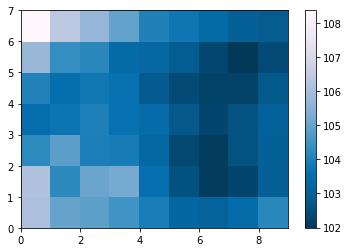

In [43]:
# This block is for visualising the output from the dqstepper
def plot_heatmap(x1, dqs):
    q = dqs.predict_q(x1)
    n = dqs.no_actions
    q_mat = np.zeros((n[1], n[0]))
    for i in range(len(q)):
        q_mat[int(dqs.x_in[i,6]), int(dqs.x_in[i,5])] = q[i]
    fig, ax = plt.subplots()
    heatmap = ax.pcolor(q_mat, cmap='PuBu_r')
    fig.colorbar(heatmap, ax=ax)
    plt.show()

x1 = [0, 0, 0, 0, 1]
x2 = [0, 0, 0, 0, -1]

plot_heatmap(x1, dqs)
# plot_heatmap(x2, dqs)

In [44]:
# This block animates the stepper 
no_steps = 10
v_init = [0.0, 0.0]
state = env.reset_env([0.0, 0.0, v_init[0], v_init[1]], no_steps*step_time)
epi_cost = 0
for n in range(no_steps):
    action = dqs.predict_action_value(state)[0]
    next_state, cost, done = env.step_env(action, step_time)
    print(action, cost, done)
    epi_cost += cost
    state = next_state
#     if done:
#         print(epi_cost)
#         break
print("showing episode...")
env.show_episode(5)

[7, 5] 1.9027229466864557 False
[0, 1] 103.77555769830187 True
[5, 4] 106.61811072016361 True
[4, 2] 116.6122072835328 True
[4, 6] 133.48285077291644 True
[8, 6] 171.80980596367803 True
[8, 6] 243.5801109510074 True
[8, 6] 393.7394246170362 True
[8, 6] 690.0399690558282 True
[8, 6] 1291.1644298549513 True
showing episode...


<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABRmW1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIHIyODU0IGU5YTU5MDMgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE3IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9OSBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MjUgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAABZgZYiE
ADP//vbsvgU1/Z/QlxEsxdpKcD4qpICAdzTAAAADAAB5FfwSZP1AY4BPTxDXj4KQzU/N/Y99dGHI
szbodIp9ItDG8zk1oVl9zWyV73qUGoiqBOeJN8mOGHAxCggJfYd1k55u6xxibsYAAAMAQRav/fWO
8pMuJ5Z/WyOiduwVKYqkNi8bobDdl+mMbD7knFuX5t1JrjOx2FfMFU9cvQTxNRssIhLTtZKv5vn7
fnWlbf8hI8qKrgu2ZZivB8Lh+peXFJsLxq9b/+yeUgk5azzBpbub6HIfRpojUMd+GHezE9KGTc8y
BZeuv6bpI10n0+9KBIUA+0tLhyBc+wn4E1b/ZtM5qiLFM5oaxCxZQibGP/Hd0wRpHDVQujzybs2h
8oZdmgDPrQ9zjl7Op+YKb4dU/VLNSygvVraF2lPZGbTKBKqD0XScaBtKLI0dnUBr5bEsziRBm6xY
qvO1E0J2IC/rlCVZd41YlXQJjY5yrxBF8NZt/eoSqty63cTozWfqb8syrnD5AZ7g5cVV6xBluMwB
wlreiQxjqW9M5+piZVjNG3WJYsGo7ejTRO66PvzG3L9k3gb1OcbkRbfyjM+DDRyWaO+TjD5C45ds
drI9qwSl9kWdK9B0UemOOSWlZx/ajumbYfCT0k+8JxunEfjHGkv5q+oxZVdhUppXs0kJwxnB8/uN
kWmGPUxzWtwFO3EruWeFuvCHl5W2/RdL3mPIiegk3Rms9XLJ5VFlJwTQQxWc3JDjxNK1Istsd5nd
i4ROCoc3pUe253Blw62QUM6EafMZVSkAkLJXfKfYoRW66LlpsUDTQYlBK3SeAhfY+NUYZhwRS4zV
/0VG5r1Do/dgV6LqWdLEPkWe7YszmBC0bSERfeoAeQxQJpdXKlIuhqj7QXUw6v8USyvKpHYggjJ2
rr9ftvRXw4qoNdylLX0liOSqnhsiD08QL3NgQ6FHv4wO4ZbyCGDI+sklmRQ38S8YgHl0haehYRLp
gefQLuxtT3Adfj2BoVaZB0F5Ue/OvZCb4JDxYQQzMZANIchpDbEDkZIGXRrJsi9mGBhnx8V/M3bP
/9m25fe79P/ngElfU98zIsOaYwVRHX9vXF8Vw3eMy+0a2Wwq8PJNtx1LY5iP/uCSR7JPO4lXEhuc
Rm9xgQ0PaPXn89fM/7FPMy+SBRtjQc+ThLhwve19ddLXOn/ZxhfIylK9M7m/N13vGsFDI0Q+gkUK
XB5Ejh4++jqnFpcFAtHpPYU6A29p/UplMnZRSPcRiAgh6vPSQSGN7Uft7wF9E9v87/feZh6mUF5d
2sxP/jXRN4R3RjMANsGr57ETduahjgfCpa1il9ioT7OEFbhLV7OsgAeOySAW9v+83KiKsUOC3+OV
Iby7WMAk6pvFbB5ULfBo0dPnHRtIaNSgF66OXN+jL/ZboYMxfKx10kxEZHwWGHCpaP0eb1HXnhiw
WaSyP07XOnHyjslnFQii8iOilgq+xkkHz0ycl1Zn1g/DSKA/j1414yb0OXc4lDr3NQndDQa1wA7e
LSFl9Yvl8o4EPQNgUhf4h7/w4+PT6w83UbEBKt7nNIkVV433xgVWAx+dHIlWc5V/Y5B7t2WSeEYd
fTM2UX4Ac4vGwMNh0RCfGyy3C9ssJnIIB7/AnLMjh38FowtGaHQdm9AzP9nLpOVSQVjJ4PsVH3re
zYmeKS5OfpEaqugO76M+JRebCR/JHh5sGdTQF/xyK7WnjrNM0Bk178s4hbCnPBWs08yKAjYQJmWg
F6XAynt/ELBLlbsIDdvlTCKrJaUFicCm1on3atUehjIln5PIRyVH/4u4F4e2QSfItOr8unPqvduk
D77XlTQmyg4ktzk//P6OfUM4SZmttwEOMwtpwDtIPzQOozdzk+sGQH6xWjslyIqjXpScp4xcDlfW
D0xB7FRB0xzWnqD98+jzqDXWGAhoJ9D+WH+71/vqyGTdtm4pklANq21YBzcem2CBWMbbnr2cCbBJ
JhG4oMdqA056KiUviSva4iwHEzsLPzkrxR2tr5pv60nFtWwXPeZiq7lqZTpX/L6wkM+AemuJWeBb
MN1Lao+nsen36YklX4tqnZfyXQDKLHv828zmHB29lRapiHWGz50kMoiEFu4sZIkIB4lpJespH5NA
Td3EmtCSA5B97D0pO3A1K/+Oog7naE2CSiHUVafDIO7rIvnfhg0scuuzQXaA9f/MGxIfxsLH5ELS
/Apie/mj5FrvDOm9MgTwwKxwz16s/wYGUp6h9TE0kh0YipvGLbmFdYBwAfLezNw2koZrBBRaJPH/
9M5H4PfOHCtn7zEL4uUVwLBpRET/xiJZ4IlbUJFPfksFcVg9/AnABKFbIF1r7qulEEXbkawPWIxd
rlFCiFMsCPqWy9529wEalm5E6ttlrOBh//1qVqV6NGTFjWSxWOBOxONk+mnGlLy7QEWBGzfwEnrk
h1usj2pHsilnXwwqZPq8cJidpGskRf2GJPwL63Yu7jMVf0dyEWJ6mb2rRCzjdb2fvBn8JEUXJIRX
liRGYKDE5BJBqPLf7+TCJYtrCMysIDTNz3H7I1AJz0WSZ9TVwlArN1Q7vSl88doIjwn534C2GhqN
ldNWUl7QPBtCBT1oIKB8OqnfkJWp3IA6XMv8fT8OHFhO46D5srDalMksMHphWNCoZeZ//lWEgw4e
HZDxv+0bDm8qK9GDvMVlr/8T0VOcjmgheyZxWJyyXkH0fJLh3BuwH1F1H0ulT/Y2ltBzdL3voUzH
cUFjn39xOUKVl4Qjxdte6tLfUsG5qO+0UxCoeJagfR6J2xyd+DvDlcJMs4W+bjjiG2Jl/iwjRegN
mQAF60ifBopLg3/jmPo+vGFq5gee//wxncERh5qH9RtGAlfr3DLeWrgRrkKmKNFme/lYXCXIMqpN
1CzONdErzQlBSR8vdx7u0